In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import os
from utils.common import NeuralNet, fit
torch.manual_seed(42)

In [2]:
# %%
def load_data(Test, train_size):
    # REPLACE THE ( FIRST COLUMNS BY SOBOL VALUES)
    sobol = np.loadtxt('Data/samples_sobol_Task2.txt', delimiter=' ', dtype=np.float32)
    print(f'sobol size = {sobol.shape}')
    xy_101 = np.loadtxt('Data/TrainingData_101_Task2.txt', delimiter=' ', dtype=np.float32)
    xy_101[:, :-1] = sobol
    print(f'xy_101 size: {xy_101.shape}')
    xy_401 = np.loadtxt('Data/TrainingData_401_Task2.txt', delimiter=' ', dtype=np.float32)
    xy_401[:, :-1] = sobol[:xy_401.shape[0], :]
    print(f'xy_401 size: {xy_401.shape}')
    xy_1601 = np.loadtxt('Data/TrainingData_1601_Task2.txt', delimiter=' ', dtype=np.float32)
    xy_1601[:, :-1] = sobol[:xy_1601.shape[0], :]
    
    xy_1601_test = xy_1601[:round(train_size*xy_1601.shape[0]),:]
    print(f'xy_1601 size: {xy_1601.shape}')
    if Test==False:
        datasets_meshes = [xy_101,xy_401, xy_1601] # Full training
        return datasets_meshes
    else:
        datasets_meshes = [xy_101,xy_401, xy_1601_test] # Test
        test_set = xy_1601[round(train_size*xy_1601.shape[0]):,:]
        print(f'Train size: {xy_1601_test.shape}')
        print(f'Test size: {test_set.shape}')
        return datasets_meshes, test_set

train_size = 0.75
Test = False
if Test:
    print('TESTING')
    datasets_meshes,test_set = load_data(Test, train_size)
else:
    datasets_meshes = load_data(Test, train_size)
# %%
training_sets = list()
training_sets.append(datasets_meshes[0])

for l in range(1, len(datasets_meshes)):
    ns = datasets_meshes[l].shape[0]
    assert ((datasets_meshes[l][:ns, :-1] == datasets_meshes[l - 1][:ns, :-1]).all())

    obs_diff = datasets_meshes[l][:ns, -1] - datasets_meshes[l - 1][:ns, -1]
    print("Variance of details at level l =", l ,": ",np.var(obs_diff))
    ts_detail_l = np.concatenate([datasets_meshes[l][:ns, :-1], obs_diff.reshape(-1, 1)], 1)
    training_sets.append(ts_detail_l)

sobol size = (2560, 8)
xy_101 size: (2560, 9)
xy_401 size: (640, 9)
xy_1601 size: (160, 9)
Variance of details at level l = 1 :  1.9109805e-06
Variance of details at level l = 2 :  1.6335908e-07


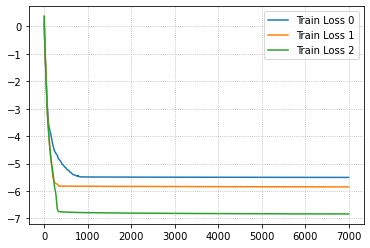

In [3]:
approximate_models = list()

for i, current_ts in enumerate(training_sets):
    inputs = torch.from_numpy(current_ts[:, :-1]).type(torch.float32)
    output = torch.from_numpy(current_ts[:, -1].reshape(-1, 1)).type(torch.float32)
    batch_size = inputs.shape[0]
    training_set = DataLoader(torch.utils.data.TensorDataset(inputs, output), batch_size=batch_size, shuffle=True)

    model = NeuralNet(input_dimension=inputs.shape[1],
                      output_dimension=output.shape[1],
                      n_hidden_layers=4,
                      neurons=20,
                      regularization_param=0.0,
                      regularization_exp=1,
                      retrain_seed=128) # 0.004886864684522152 Validation error

    # Random Seed for weight initialization
    retrain = 200
    # Xavier weight initialization
    #init_xavier(model, retrain)
    # print(model(inputs))

    optimizer_ = optim.LBFGS(model.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    n_epochs = 7000
    history = fit(model, training_set, n_epochs, optimizer_, p=2, verbose=False)

    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, n_epochs + 1), np.log10(history), label=f"Train Loss {i}")
    plt.legend()

    approximate_models.append(model)

In [4]:
def predcit_with_ml(list_models, inputs_):
    output_ = torch.zeros((inputs_.shape[0], 1))
    for i in range(len(list_models)):
        output_ = output_ + list_models[i](inputs_)
    return output_

In [5]:
if Test:
    testing = test_set
    test_output = torch.from_numpy(testing[:, -1].reshape(-1,1)).type(torch.float32)
    testing = (testing[:,:8])
    test_inputs_val =  torch.from_numpy(testing[:, :8]).type(torch.float32)
    test_prediction_ml_val = predcit_with_ml(approximate_models, test_inputs_val).reshape(-1, 1)
    err_ml = (torch.mean((test_output - test_prediction_ml_val) ** 2) / torch.mean(test_output ** 2)) ** 0.5
    print(f'Validation error on 1601 data: {err_ml.item()}') # 7000 epochs: 0.004886864684522152

In [6]:
#full predictions
if Test == False:
    test_inputs = torch.from_numpy(np.loadtxt('Data/TestingData_Task2.txt', delimiter=' ', dtype=np.float32))
    test_pred_ml = predcit_with_ml(approximate_models, test_inputs).reshape(-1, ).detach()
    test_pred_ml = (test_pred_ml.reshape(-1, 1))
    test_pred_ml = test_pred_ml

In [ ]:
    ## Make Submission
with open('/Users/jonas/Documents/ETHZ/FS2022/Deep Learning for scientific computing/Project1/Task2/Task2def_check.txt', 'w') as f:
    for idx in range(len(test_pred_ml)):
        cf = test_pred_ml[idx].item()
        line = str(cf)
        f.write(line)
        f.write('\n')